# Deep Learning Image Classification for Sentiment Analysis

For this hackathon challenge you will be using a deep learning convolutional neural network for image classification. 

To get you started, we have provided you with starter code using the __[fastai](https://docs.fast.ai)__ library. Fastai is a very flexible library that allows you to accomplish complicated deep learning tasks with very few high level lines of code. As an added benefit, the default settings for most Fast.ai functions help you achieve near state of the art (SOTA) results. At the same time, this library is very easy to customize with callback functions, if you want to do something more sophisticated.

The base line model you have been provided uses the ResNet18 architecture, and was trained with images obtained using Google Images (Usage Rights=Creative Commons licenses) and Bing Images (License=Public domain) for our specific task of classifying images of facial expressions into ***positive*** or ***negative*** sentiments.

If you would like more background on deep learning and image classification, an excellent source is the online fast.ai book, available at:

__[Fastbook](https://github.com/fastai/fastbook)__ 
*Open sourced pre-print version of Deep Learning for Coders with fastai & PyTorch: AI applications Without a PhD,by Jeremey Howard and Sylvain Gugger, ISBN-13: 978-1492045526*

In [280]:
from fastbook import *
from fastai.vision.widgets import *

## Working with multiple GPUs

The Standard_NC24 vm instance you are working with has 4 NVIDIA Tesla K80 GPUs. The challenge you have been given should be able to run well on a single GPU. This allows you to have multiple team members working on independent GPUs, or train different models at the same time. 

Using the function *`torch.cude.set_device()`*, you can assign a specific GPU to your notebook. The valid range of device numbers for your VM is 0 to 3.

In [281]:
# Select GPU 0
torch.cuda.set_device(2)

## Setting up you model

To get you started on training your first model, check to make sure the following parameters are set:
1. Set the path to the dataset for training and validation
2. Specify the CNN architecture. In this example we are starting with ***resnet34***.
3. Set the batch size for your data loader. This determines the number of examples are presented to the model in each iteration of training. Depending on the size of your GPU card's memory, you maybe be to use a larger value. For a Tesla K80, bs=32 or 64 is reasonable. If you use a value that is too high for your hardware, you are likely to cause a Cuda out of memory error and have to reset.

In [282]:
# Set path to the development dataset
path = Path('../dataset')

# Specify a CNN architecture for the learner. Pretrained ResNet is avaialblein many flavors the number
# indicates the number of layers. The resnet18 model is the smallest pretrained resnet model in the
# fastai library. You can try larger ones such as resnet34 or resnet50.

arch = resnet34
arch_str = 'resnet34_with32_negfocused'

# Mini-batch size (default=64). You can try other values that are a power of 2. Common values are 16, 32, 64.
bs=32

# Construct the name for the .pkl file for exporting the model at the end
pkl_fname = "model_" + arch_str +".pkl"

In [283]:
# Check the filename to make sure it makes sense. You may want to save different versions of your model
# as you experiment with settings. I recommend you use a descriptive name.

pkl_fname

'model_resnet34_with32_negfocused.pkl'

### Set up your *Data Block* and *Data Loader*

***fastai*** makes it easy to build your data pipeline using just the ***DataBlock*** class and ***dataloaders*** function. Refer to __[docs.fast.ai](https://docs.fast.ai)__ for source code and examples. The library offers many convenient transform functions to preprocess and augment the data you are loading to train the model. Chapters __[2](https://github.com/fastai/fastbook/blob/master/02_production.ipynb)__, __[3](https://github.com/fastai/fastbook/blob/master/03_ethics.ipynb)__ and __[5](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb)__ of the __[Fastbook](https://github.com/fastai/fastbook)__ offer great information and practical advice on how can you train a high performing image classifier.

In [284]:
faces = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),
                  get_y=parent_label,
                  item_tfms=Resize(224))

In [285]:
dls = faces.dataloaders(path,bs=bs)

### Check your data

It is good practice to get a quick visual check of your data to make sure it makes senese to you.

The first objective is to make sure the DateBlock is built correctly. *`summary()`* is a useful function to diagnose DataBlock problems. More details are in Chapter __[2](https://github.com/fastai/fastbook/blob/master/02_production.ipynb)__ of the Fastbook, but you can see from below that a lot of detailed information is displayed about how the dataset is used to construct a DataBlock, including the number of files in the dataset (394), how it is split into training (316) and validation (78) sets. It also shows that the categories are extracted from parent_label, meaning the directory path. In this case, the dataset directory is called ***dataset*** and the subdirectories ***pos*** and ***neg*** act as the category labels. This makes it easy to add, move or remove images to/from your dataset without having to manually rename the image files. You can also verify that the images are all resized to a uniform size of 224x224, which are the dimensions of the data used to pretrain the model.

Remember the use case for this challenge is a retail point-of-sale (RPOS) system that is camera-enabled. Consider what kind of images the camera is likely to be capturing and processing to perform sentiment analysis. Ideally the subject should be framed in the center of the image. Deep learning models typically require square images. Although ***fastai*** can work with images of any size, during model validation the library will extract a center cropped section of a large image. If most of your training images contain subjects that are off center or are zoomed out too far, chances are good that your model will not be shown the relevant section of those images during training. This can result in a poorly performing model.

**Note:** The holdout test set with which your competition submission will be scored against will consists of images of subjects with a range of skin colors, genders, ages,lighting conditions, and generally be posed at an angle that approximates what a RPOS camera is likely to see in production. As explained at the Technical Workshop, your model will be measured using the __[F1 Score](https://medium.com/swlh/explaining-accuracy-precision-recall-and-f1-score-f29d370caaa8)__ metric.

In [286]:
# Uncomment the next line to help debug DataBlock errors. The summary() function gives a lot of 
# information and is a good sanity check for what you expect to see the model be fed during training.

faces.summary(path)

Setting-up type transforms pipelines
Found 471 items
2 datasets of sizes 377,94
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../dataset/pos/pos_006D.jpeg
    applying PILBase.create gives
      PILImage mode=RGB size=275x183
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../dataset/pos/pos_006D.jpeg
    applying parent_label gives
      pos
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=275x183, TensorCategory(1))


Setting up after_item: Pipeline: Resize -- {'size': (224, 224), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, '

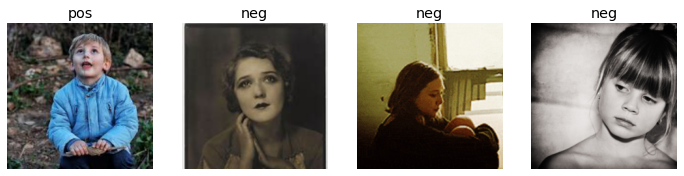

In [287]:
# Visualize part of one batch of data to catch anythin unexpected. See if you agree with
# the image labels.

dls.show_batch(max_n=4, nrows=1, ncols=4)

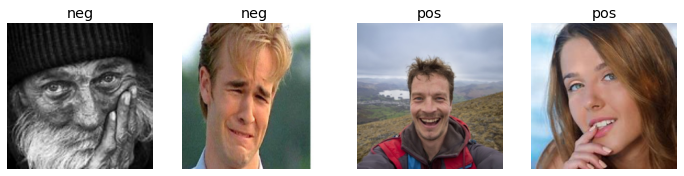

In [288]:
# Visualize part of one batch of from the training set to catch anything unexpected. See if you agree with
# the image labels. Also look for any issues such as bad cropping.

dls.train.show_batch(max_n=4, nrows=1)

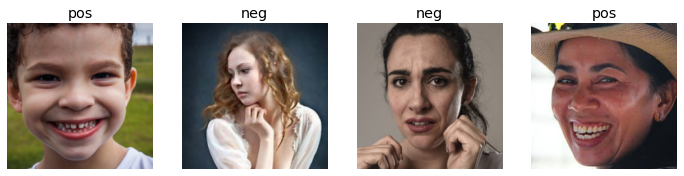

In [289]:
# # Visualize part of one batch of from the validation set to catch anything unexpected. See if you agree with
# the image labels. Also look for any issues such as bad cropping.

dls.valid.show_batch(max_n=4, nrows=1)

### Fine-tuning a ResNet model 

We are using a CNN model that has been pretrained with millions of ImageNet images. 

By doing this, we are taking advantage of transferred learning to our specifc task of classifying facial expressions into ***positive*** and ***negative*** sentiments. This pretrained model already has representations of what many things look like -- including human faces -- we just need to fine-tune it with specific examples of our task.

The following *`learn.fine_tune()`* call speficies that for the first 4 epochs of training, new layers added to the head of the model for transfer learning should be trained using our dataset, while the rest of the model should be frozen so that their previously learned weights are not disturbed. After that, unfreeze all layers in the model and train for an additional 10 epochs.

This is technique allows us to teach the model a new task using labeled examples numbered in the hundreds, instead of tens of thousands or millions. This is an example of what you can do with ***small data*** if you have the right kind of pretrained models that you can leverage.

In [290]:
learn = cnn_learner(dls, arch=arch, metrics=[error_rate, F1Score()])
learn.fine_tune(epochs=15, freeze_epochs=5, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,f1_score,time
0,1.366772,0.800630,0.393617,0.554217,00:04
1,1.105282,0.681568,0.319149,0.687500,00:05
2,0.913790,0.811831,0.297872,0.688889,00:05
3,0.752910,1.071003,0.297872,0.708333,00:05
4,0.658033,1.153301,0.340426,0.680000,00:04


epoch,train_loss,valid_loss,error_rate,f1_score,time
0,0.422979,1.009824,0.319149,0.687500,00:05
1,0.316267,0.881539,0.287234,0.732673,00:04
2,0.238979,0.842896,0.255319,0.744681,00:05
3,0.205031,0.650191,0.202128,0.808081,00:05
4,0.176484,0.604705,0.191489,0.823529,00:05
5,0.153393,0.897178,0.234043,0.784314,00:04
6,0.135999,0.991484,0.202128,0.808081,00:05
7,0.120430,0.921703,0.180851,0.824742,00:05
8,0.103502,1.059976,0.212766,0.807692,00:05
9,0.092950,0.877125,0.180851,0.834951,00:05


### Model training loss plot

A quick way to get a sense of how your model training went is by revieinw the loss plot. If you see the validation loss curve follow a "U" shaped curve, decreasing initially then reversing higher, while the training loss descreases asympotically towards zero, your model may have overfitted. You will need to consider adding more training data to help your model generalize better, or consider if your model architecture is too large for your dataset (i.e. Has too many parameters).

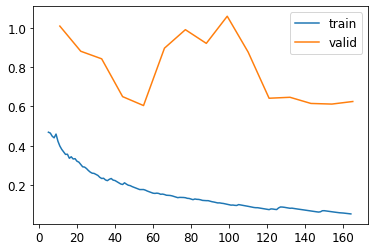

In [291]:
learn.recorder.plot_loss()

### Confusion matrix as a debugging tool

A quick way to visualize mistakes that the model is making is to use a confusion matrix. In ***fastai***,  *`plot_confusion_matrix()`* creates a confusion matrix from a learner. You can easily seee in the boxes actual values versus predicted values.

In the example below, 12 instances of positive images were predicted to be negative, and 13 negative images were predicted to be positive.

Using *`plot_top_losses()`* we can easily see the top 25 losses to help identify the mistakes we found using the confusion matrix.

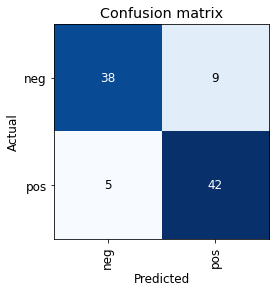

In [292]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [293]:
# A simplier way to see the confusion matrix

interp.most_confused(min_val=5)

[('neg', 'pos', 9), ('pos', 'neg', 5)]

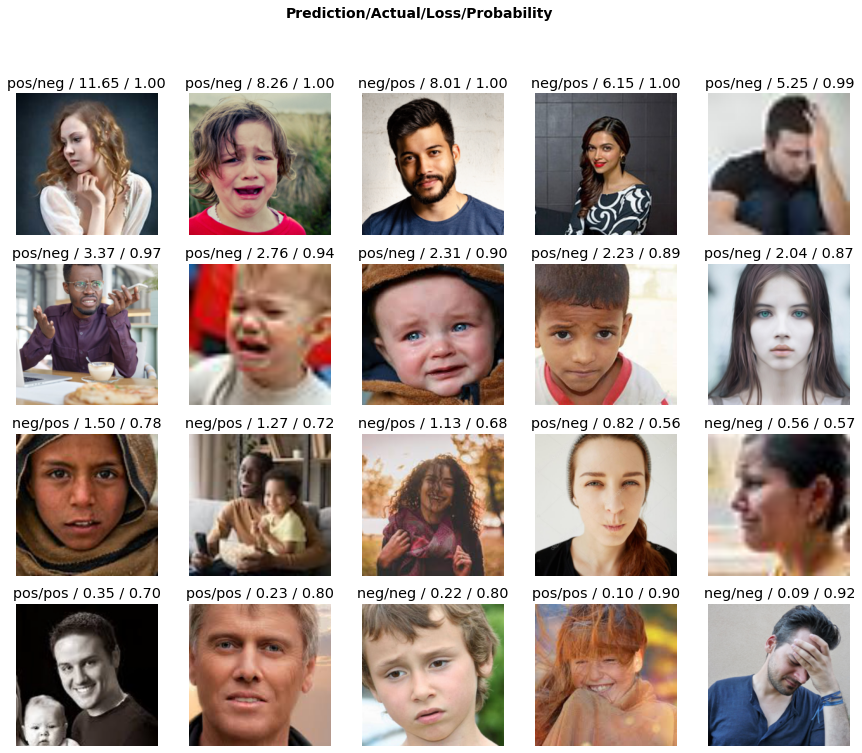

In [294]:
# You can use plot_top_losses to visualize the top mistakes. You can get a count of 
# misclassifications from the Confusion matrix above. 

interp.plot_top_losses(20, ncols=5)

In [295]:
# Useful tip:
#
# Need to see the source code to a library function? Try the "??" shortcut:

#interp.plot_top_losses??

# Need to see the API documentation for a library function? Try the doc() shortcut:

#doc(interp.plot_top_losses)

## Data cleansing

You can select the class (e.g. pos or neg) and dataset (Valid or Train) from the dropdown list.

**Step 1**:Next you can go through the images and select from the dropdown list below each image one of
four actions to help you fix any mislabeled data: \<Keep\>, \<Delete\>, pos, or neg. 

**Step 2**: Once you have made the corrections in ***Step 1***, run the cell labeled ***Step 2*** to execute the changes.


If you want to do more cleaning, you can return to ***Step 1*** to select a different label or dataset and
repeat the process. Occassionally you may encounter an error in a subsequent iteration if you deleted or moved files that ImageClassifierCleaner expects to find. In that case, you will have to run the notebook again.


In [296]:
# Step 1

cleaner = ImageClassifierCleaner(learn)
cleaner

In [297]:
# Step2
#These two loops do the actual deleting and moving (relabeling) of images selected above

for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Exporting your model for inferencing and submission

In [298]:
path = Path('../models')
learn.export(path/pkl_fname)